<h1 style="text-align: center;color:blue"><em>Daniel Juravski 206082323</em></h1>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.calibration import calibration_curve
from pprint import pprint

# loading data
data = np.loadtxt('../data/heart_disease_uci/heart.csv', delimiter=",", skiprows=1)
X = data[:, :-1]
Y = np.asarray(data[:, -1], dtype=int)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.2, random_state=1)

**It is worth mentioning that since the data is very small (303 samples) and much diverse (13 features), the smallest changes at the train-test data split ratio or different random seeds, can cause quite different results.**

# Question 01:

In [2]:
log_reg = LogisticRegression(max_iter=10000, random_state=0)
# the concatenate here foe keeping the randomness of the samples
results = cross_validate(log_reg,
                         X=np.concatenate((X_train, X_test), axis=0),
                         y=np.concatenate((y_train, y_test), axis=0),
                         cv=5,
                         scoring=['accuracy', 'neg_mean_squared_error'], return_train_score=True)

train_accuracy = results['train_accuracy']
test_accuracy = results['test_accuracy']
train_neg_mean_squared_err = results['train_neg_mean_squared_error']
test_neg_mean_squared_err = results['test_neg_mean_squared_error']
print("Train folds acc: {0} (mean: {1})".format(train_accuracy, np.mean(train_accuracy)))
print("Test folds acc: {0} (mean: {1})".format(test_accuracy, np.mean(test_accuracy)))
print("Train folds loss: {0} (mean: {1})".format(train_neg_mean_squared_err, np.mean(train_neg_mean_squared_err)))
print("Test folds loss: {0} (mean: {1})".format(test_neg_mean_squared_err, np.mean(test_neg_mean_squared_err)))

log_reg.fit(X_train, y_train)
y_pred = log_reg.score(X_train, y_train)
y_test_pred = log_reg.score(X_test, y_test)
print("Train data acc: {0}".format(y_pred))
print("Test data acc: {0}".format(y_test_pred))

Train folds acc: [0.88016529 0.85950413 0.8553719  0.83950617 0.86831276] (mean: 0.8605720504710404)
Test folds acc: [0.80327869 0.85245902 0.85245902 0.91666667 0.71666667] (mean: 0.8283060109289616)
Train folds loss: [-0.11983471 -0.14049587 -0.1446281  -0.16049383 -0.13168724] (mean: -0.13942794952895965)
Test folds loss: [-0.19672131 -0.14754098 -0.14754098 -0.08333333 -0.28333333] (mean: -0.17169398907103825)
Train data acc: 0.8760330578512396
Test data acc: 0.7213114754098361


In that part, I've set the ```penatly=none``` to avoid any type of regularization. We can see that in the inner fields (and the overall fitting) the train fields' metrics score (in this exercise I used the accuracy metric all over the models) is much higher than the test fields' scores. Hence we can conclude that in that case the model is overfitted.

# Question 02:

In [3]:
log_reg_cv1 = LogisticRegressionCV(solver='liblinear', penalty='l1', cv=5, max_iter=10000, scoring='accuracy')
log_reg_cv1.fit(X_train, y_train)
# pprint(log_reg_cv1.scores_)
y_pred = log_reg_cv1.score(X_train, y_train)
y_test_pred = log_reg_cv1.score(X_test, y_test)
print("Train data acc: {0}".format(y_pred))
print("Test data acc: {0}".format(y_test_pred))

log_reg_cv2 = LogisticRegressionCV(penalty='l2', cv=5, max_iter=10000, scoring='accuracy')
log_reg_cv2.fit(X_train, y_train)
# pprint(log_reg_cv2.scores_)
y_pred = log_reg_cv2.score(X_train, y_train)
y_test_pred = log_reg_cv2.score(X_test, y_test)
print("Train data acc: {0}".format(y_pred))
print("Test data acc: {0}".format(y_test_pred))

log_reg_cv3 = LogisticRegressionCV(solver='saga', penalty='elasticnet', l1_ratios=[.1, .5, .7, .9, .95, .99],
                                   cv=5, max_iter=10000, scoring='accuracy')
log_reg_cv3.fit(X_train, y_train)
# pprint(log_reg_cv3.scores_)
y_pred = log_reg_cv3.score(X_train, y_train)
y_test_pred = log_reg_cv3.score(X_test, y_test)
print("Train data acc: {0}".format(y_pred))
print("Test data acc: {0}".format(y_test_pred))

Train data acc: 0.8553719008264463
Test data acc: 0.7377049180327869
Train data acc: 0.8760330578512396
Test data acc: 0.7377049180327869
Train data acc: 0.8553719008264463
Test data acc: 0.7540983606557377


In that part, I've trained the logistic regression model using 3 types of regularization: $l1$, $l2$, and a combination of these both - $elastic net$. We can see that in the overall fitting, the train metric scores and the test metric scores difference is a bit low than in the previous (un-regularized) model. We can see that different types and stregnth of regularization leads to different fitting scores, what amounts to less overfitted models. In addition, we can explore the stregnth of the regularization (the `Cs_` values of the model) and infer that they influence a lot the metric score (the `scores_` values of the model).

# Question 03:

In [4]:
rfc_model = RandomForestClassifier(random_state=0)
model_params = {
    'n_estimators': [10, 20, 30, 50, 100, 200],
    'max_features': ['sqrt', 3, 4, 5],
    'max_depth': [2, 3, 4, 5, 6, 7, 8]
}
cv_rfc = GridSearchCV(estimator=rfc_model, param_grid=model_params, cv=5)
cv_rfc.fit(X_train, y_train)
pprint(cv_rfc.best_estimator_.get_params())

y_pred = cv_rfc.best_estimator_.score(X_train, y_train)
y_test_pred = cv_rfc.best_estimator_.score(X_test, y_test)
print("Train data acc: {0}".format(y_pred))
print("Test data acc: {0}".format(y_test_pred))

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 4,
 'max_features': 4,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}
Train data acc: 0.9173553719008265
Test data acc: 0.7704918032786885


The results of this models are mixed, on the one hand it semms that there is an overfitting (comparison of the train and test metric scrores), but on the other hand it's test score is the highest between all the above models.
The optimal number of trees that the model has found is `'n_estimators': 100` (worh mentioning that based on other random seeds the result was 20).

# Question 04:

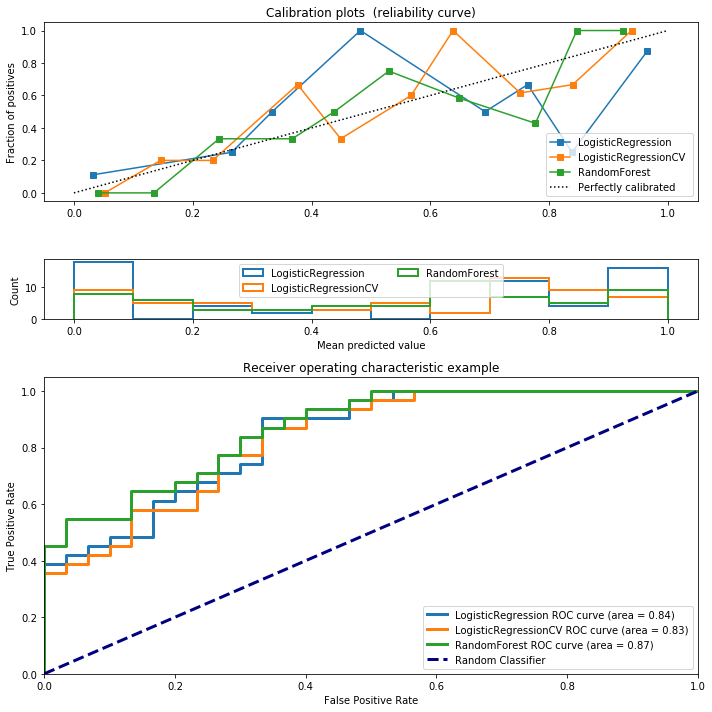

In [5]:
def make_roc_caliboration_curves(model, label):
    prob_pos = model.predict_proba(X_test)[:, 1]  # probs for 1-class
    fpr, tpr, _ = roc_curve(y_test, prob_pos)
    roc_auc = auc(fpr, tpr)

    fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=10)
    ax1.plot(mean_predicted_value, fraction_of_positives, "s-", label="%s " % label)
    ax2.hist(prob_pos, range=(0, 1), bins=10, label=label, histtype="step", lw=2)
    ax3.plot(fpr, tpr, lw=3, label='%s ROC curve (area = %0.2f)' % (label, roc_auc))

fig = plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((6, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((6, 1), (2, 0), sharex=ax1)
ax3 = plt.subplot2grid((6, 1), (3, 0), rowspan=3)

make_roc_caliboration_curves(log_reg, "LogisticRegression")
make_roc_caliboration_curves(log_reg_cv3, "LogisticRegressionCV")
make_roc_caliboration_curves(cv_rfc, "RandomForest")

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

ax3.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--', label="Random Classifier")
ax3.set_xlim([0.0, 1.0])
ax3.set_ylim([0.0, 1.05])
ax3.set_xlabel('False Positive Rate')
ax3.set_ylabel('True Positive Rate')
ax3.set_title('Receiver operating characteristic example')
ax3.legend(loc="lower right")

plt.tight_layout()
plt.show()

In this part, all the models predict the risk probabilities of the unlearned test data. Via the calibration plots, we can see that while in the predicted probability range of [0.0-0.3]  and around the 1.0, the predictions were estimated similar to the real probability of the event. In contrast, the calibration at the [0.4-0.8] probability prediction values seemed to be very raw and not calibrated. On the one hand, seems that the models do fine estimates when the predicted probability is at the edges (absolute), on the other hand, since we are talking about risk prediction - that by definition the probability of the event should be predicted rather than its class, I'm not sure that these models can be much useful for this case.


# Question 05:

Let's go over how the bootstrap works. We have an original sample $x_1,x_2, …, x_n$ with $n$ items in it. We draw items with replacement from this original set until we have another set of size $n$.

From that, it follows that the probability of choosing any one item (say, $x_1$) on the first draw is $\frac{1}{n}$. Therefore, the probability of not choosing that item is $1-\frac{1}{n}$. That's just for the first draw; there are a total of $n$ draws, all of which are independent, so the probability of never choosing this item on any of the draws is $(1-\frac{1}{n})^n$.

Now, let's think about what happens when $n$ gets larger and larger. We can take the limit as $n$ goes towards infinity, using the usual calculus tricks:
$$\lim_{n\to\infty} (1-\frac{1}{n})^n = \frac{1}{e} \approx 0.368$$

That's the probability of an item not being chosen. Subtract it from one to find the probability of the item being chosen, which gives you $0.632$.


# Question 06:

We can create a model based on the GBM data including the demographic features, once with no regularization and once with. We expect that if these additional features are addable value to the model, we'll get higher scores both on the train and the test data. If these additional features don't add any information, we expect to get a higher score on the train data than the test data (on the un regularized model), and the probably same scores as before adding these features on the regularized model. We can check these train and test scores using the cross-validation method.